# mT5

In [1]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import MT5TokenizerFast, MT5ForConditionalGeneration

/home/nlp/anaconda3/envs/vietnq-ner/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_LENGTH = 1024
model_id = 'google/mt5-base'

In [3]:
# Setup tokenizer
tokenizer = MT5TokenizerFast.from_pretrained(model_id)

print('BOS:', tokenizer.bos_token)
print('SEP:', tokenizer.sep_token)
print('PAD:', tokenizer.pad_token)
print('EOS:', tokenizer.eos_token)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/home/nlp/anaconda3/envs/vietnq-ner/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


BOS: None
SEP: None
PAD: <pad>
EOS: </s>


### 1. Dataset `INSTRUCTION TUNING WITH GPT-4`

In [4]:
# output repo in huggingface
output_repo = 'en-mT5-instruction_tuning-gpt4'

Load dataset

In [5]:
# import os
# os.makedirs('dataset', exist_ok=True)

# !wget https://raw.githubusercontent.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/main/data/alpaca_gpt4_data.json -P dataset

In [6]:
en_alpaca = load_dataset('json', data_files='dataset/alpaca_gpt4_data.json')['train']
en_alpaca

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 52002
})

In [7]:
en_alpaca[232]

{'instruction': 'Sort the following list in alphabetical order.',
 'input': 'Camouflage, Furniture, Plaster',
 'output': 'Camouflage, Furniture, Plaster sorted in alphabetical order:\nCamouflage, Furniture, Plaster'}

In [8]:
def prompt_no_input(row):
    return ("Below is an instruction that describes a task. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction: {instruction}\n\n### Response:\n").format_map(row)


def prompt_input(row):
    return ("Below is an instruction that describes a task, paired with an input that provides further context. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction: {instruction}\n\n### Input: {input}\n\n### Response:\n").format_map(row)

def create_prompt(row):
    return prompt_no_input(row) if row["input"] == "" else prompt_input(row)

In [9]:
print(create_prompt(en_alpaca[232]))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction: Sort the following list in alphabetical order.

### Input: Camouflage, Furniture, Plaster

### Response:



In [10]:
print(create_prompt(en_alpaca[29]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: Identify the lines of longitude that divides North and South America.

### Response:



In [11]:
def make_labelled_data(example, id):
    prompt = create_prompt(example)
    label = example['output']

    return {"id": id, "text": prompt, "label": label}

make_labelled_data(en_alpaca[232], 232)

{'id': 232,
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction: Sort the following list in alphabetical order.\n\n### Input: Camouflage, Furniture, Plaster\n\n### Response:\n',
 'label': 'Camouflage, Furniture, Plaster sorted in alphabetical order:\nCamouflage, Furniture, Plaster'}

In [12]:
print("> Making labelled dataset...")
en_alpaca_labelled = en_alpaca.map(
    make_labelled_data,
    with_indices=True,
    remove_columns=["instruction", "input", "output"],
)
print(en_alpaca_labelled)

> Making labelled dataset...
Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 52002
})


In [13]:
token_lengths = en_alpaca_labelled.map(
    lambda x: {
        'text': len(tokenizer(x['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']),
        'label': len(tokenizer(x['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']),
    }
)

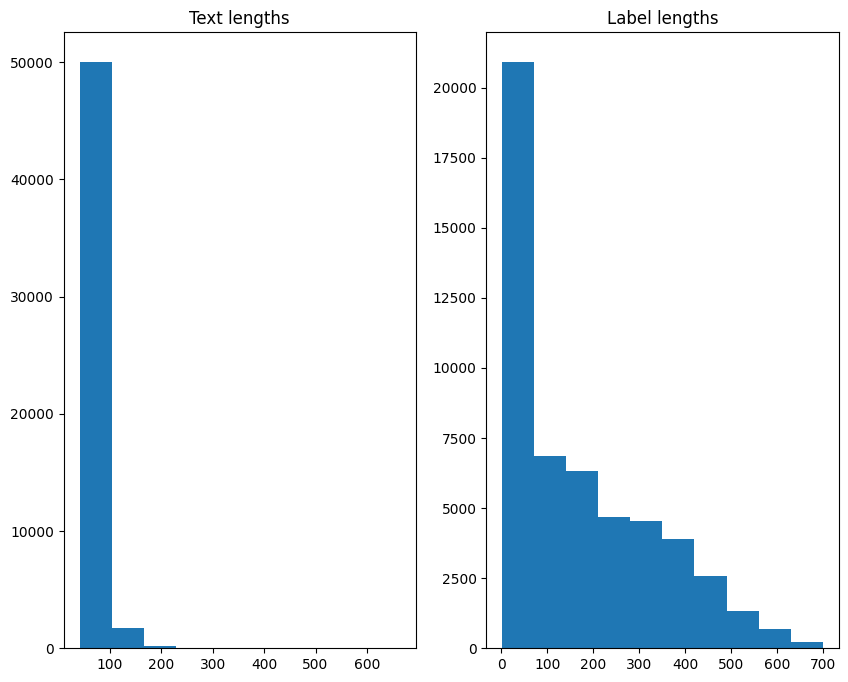

Max text length: 664
Max label length: 700
Current limit: MAX_LENGTH = 1024


In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(token_lengths['text'])
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(token_lengths['label'])
plt.title('Label lengths')

plt.show()

print('Max text length:', max(token_lengths['text']))
print('Max label length:', max(token_lengths['label']))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

In [15]:
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
en_alpaca_tokenized = en_alpaca_labelled.map(
    lambda x: tokenize(x, tokenizer, "text", "label"),
    batched=True,
    remove_columns=["text", "label"],
)

print(">> Dataset is ready:")
print(en_alpaca_tokenized)

> Tokenizing dataset...
>> Dataset is ready:
Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 52002
})


In [16]:
en_alpaca_tokenized[9]['input_ids'], tokenizer.decode(en_alpaca_tokenized[9]['input_ids'])

([1071,
  12704,
  339,
  461,
  66395,
  533,
  259,
  61507,
  263,
  259,
  262,
  41401,
  261,
  35885,
  345,
  514,
  461,
  13037,
  533,
  4996,
  263,
  259,
  17756,
  19730,
  260,
  70081,
  259,
  262,
  17672,
  533,
  259,
  32821,
  484,
  8593,
  263,
  287,
  19378,
  260,
  259,
  62569,
  259,
  165543,
  267,
  99574,
  346,
  714,
  259,
  98923,
  332,
  259,
  131640,
  305,
  259,
  164814,
  259,
  75107,
  263,
  259,
  62569,
  259,
  52043,
  267,
  1669,
  3513,
  71572,
  1638,
  59329,
  305,
  12255,
  287,
  9463,
  173162,
  259,
  62569,
  259,
  33632,
  267,
  1],
 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: Evaluate this sentence for spelling and grammar mistakes ### Input: He finnished his meal and left the resturant ### Response:</s>')

In [17]:
en_alpaca_tokenized[9]['labels'], tokenizer.decode(en_alpaca_tokenized[9]['labels'])

([5258,
  418,
  2956,
  259,
  131640,
  259,
  112790,
  281,
  287,
  259,
  98923,
  260,
  486,
  12382,
  345,
  259,
  98923,
  3609,
  390,
  267,
  313,
  13344,
  259,
  47149,
  1638,
  59329,
  305,
  12255,
  287,
  13306,
  2454,
  1],
 'There are two spelling errors in the sentence. The corrected sentence should be: "He finished his meal and left the restaurant."</s>')

In [18]:
print(f"> Pushing to hub: {output_repo}")
en_alpaca_tokenized.push_to_hub(output_repo)

> Pushing to hub: en-mT5-instruction_tuning-gpt4


Creating parquet from Arrow format: 100%|██████████| 53/53 [00:00<00:00, 188.00ba/s]


Uploading the dataset shards: 100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/en-mT5-instruction_tuning-gpt4/commit/4da111cf45620cc1b8147bf0abc2790b10cf6f8c', commit_message='Upload dataset', commit_description='', oid='4da111cf45620cc1b8147bf0abc2790b10cf6f8c', pr_url=None, pr_revision=None, pr_num=None)

### 2. Dataset `bkai-foundation-models/vi-alpaca`

In [19]:
# output repo in huggingface
output_repo = 'vi-mT5-instruction_tuning-bkai'

In [20]:
vi_alpaca = load_dataset('bkai-foundation-models/vi-alpaca', split='train')
vi_alpaca

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 50006
})

In [21]:
vi_alpaca[232]

{'instruction': 'Tìm bài hát theo lời mô tả sau.',
 'input': 'Một bản nhạc vui nhộn với giai điệu sôi động và lời ca bắt tai. Bài hát này thường được người ta nhảy theo và hát cùng trong các buổi tiệc hoặc sự kiện vui nhộn.',
 'output': 'Bài hát mà bạn mô tả có thể là một bài hát như "Happy" của Pharrell Williams. Bài hát này có giai điệu vui nhộn, nhanh chóng và lời ca tích cực, khích lệ. Đây là một bài hát phổ biến được người ta thường chơi trong các buổi tiệc hoặc sự kiện để tạo không khí vui tươi và năng động.'}

In [22]:
def prompt_no_input(row):
    return ("Below is an instruction that describes a task. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction: {instruction}\n\n### Response:\n").format_map(row)


def prompt_input(row):
    return ("Below is an instruction that describes a task, paired with an input that provides further context. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction: {instruction}\n\n### Input: {input}\n\n### Response:\n").format_map(row)

def create_prompt(row):
    return prompt_no_input(row) if row["input"] == "" else prompt_input(row)

In [23]:
print(create_prompt(vi_alpaca[232]))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction: Tìm bài hát theo lời mô tả sau.

### Input: Một bản nhạc vui nhộn với giai điệu sôi động và lời ca bắt tai. Bài hát này thường được người ta nhảy theo và hát cùng trong các buổi tiệc hoặc sự kiện vui nhộn.

### Response:



In [24]:
print(create_prompt(vi_alpaca[46000]))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: Viết một câu hỏi để yêu cầu thông tin tổng quát về lịch sử của Rome, Italy.

### Response:



In [25]:
def make_labelled_data(example, id):
    prompt = create_prompt(example)
    label = example['output']

    return {"id": id, "text": prompt, "label": label}

make_labelled_data(vi_alpaca[232], 232)

{'id': 232,
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction: Tìm bài hát theo lời mô tả sau.\n\n### Input: Một bản nhạc vui nhộn với giai điệu sôi động và lời ca bắt tai. Bài hát này thường được người ta nhảy theo và hát cùng trong các buổi tiệc hoặc sự kiện vui nhộn.\n\n### Response:\n',
 'label': 'Bài hát mà bạn mô tả có thể là một bài hát như "Happy" của Pharrell Williams. Bài hát này có giai điệu vui nhộn, nhanh chóng và lời ca tích cực, khích lệ. Đây là một bài hát phổ biến được người ta thường chơi trong các buổi tiệc hoặc sự kiện để tạo không khí vui tươi và năng động.'}

In [26]:
print("> Making labelled dataset...")
vi_alpaca_labelled = vi_alpaca.map(
    make_labelled_data,
    with_indices=True,
    remove_columns=["instruction", "input", "output"],
)
print(vi_alpaca_labelled)

> Making labelled dataset...
Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 50006
})


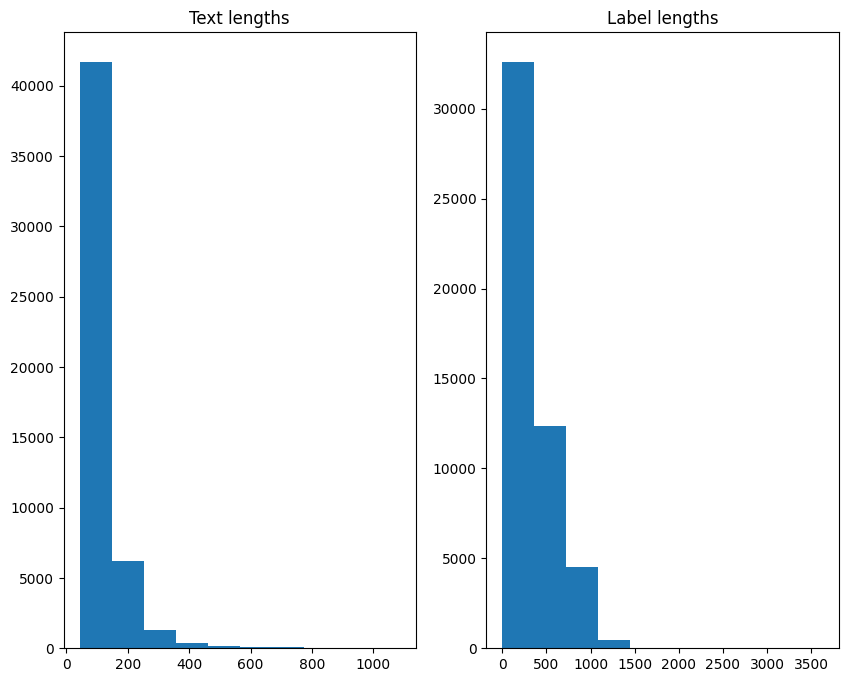

Max text length: 1086
Max label length: 3629
Current limit: MAX_LENGTH = 1024


In [27]:
token_lengths = vi_alpaca_labelled.map(
    lambda x: {
        'text': len(tokenizer(x['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']),
        'label': len(tokenizer(x['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']),
    }
)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(token_lengths['text'])
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(token_lengths['label'])
plt.title('Label lengths')

plt.show()

print('Max text length:', max(token_lengths['text']))
print('Max label length:', max(token_lengths['label']))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

In [28]:
# filter the dataset to only get those that has length of text <= 1024
vi_alpaca_labelled_dropped = vi_alpaca_labelled.filter(
    lambda x: len(x['text']) <= MAX_LENGTH
)
vi_alpaca_labelled_dropped

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 49594
})

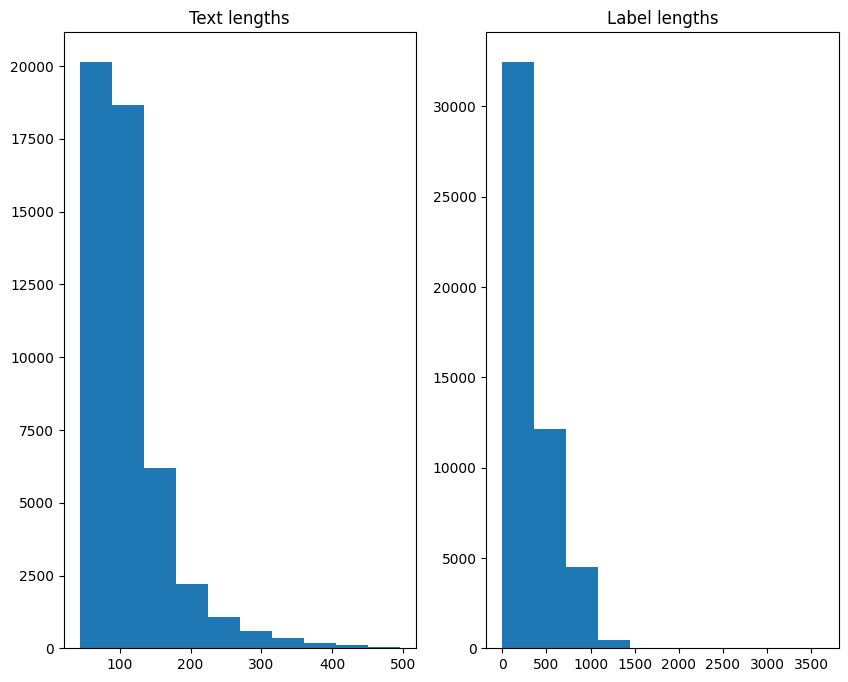

Max text length: 496
Max label length: 3629
Current limit: MAX_LENGTH = 1024


In [29]:
token_lengths = vi_alpaca_labelled_dropped.map(
    lambda x: {
        'text': len(tokenizer(x['text'], padding=False, truncation=False, add_special_tokens=True)['input_ids']),
        'label': len(tokenizer(x['label'], padding=False, truncation=False, add_special_tokens=True)['input_ids']),
    }
)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.hist(token_lengths['text'])
plt.title('Text lengths')

plt.subplot(1, 2, 2)
plt.hist(token_lengths['label'])
plt.title('Label lengths')

plt.show()

print('Max text length:', max(token_lengths['text']))
print('Max label length:', max(token_lengths['label']))
print('Current limit: MAX_LENGTH =', MAX_LENGTH)

In [30]:
def tokenize(samples, tokenizer, input_field, label_field, max_length=MAX_LENGTH):
    # Tokenize
    tokenized_input = tokenizer(samples[input_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)
    tokenized_label = tokenizer(samples[label_field], max_length=max_length, padding=False, truncation=True, add_special_tokens=True)

    return {
        'input_ids': tokenized_input['input_ids'],
        'attention_mask': tokenized_input['attention_mask'],
        'labels': tokenized_label['input_ids']
    }

print("> Tokenizing dataset...")
vi_alpaca_tokenized = vi_alpaca_labelled_dropped.map(
    lambda x: tokenize(x, tokenizer, "text", "label"),
    batched=True,
    remove_columns=["text", "label"],
)

print(">> Dataset is ready:")
print(vi_alpaca_tokenized)

> Tokenizing dataset...


Map: 100%|██████████| 49594/49594 [00:09<00:00, 5347.27 examples/s]

>> Dataset is ready:
Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 49594
})


In [31]:
tokenizer.decode(vi_alpaca_tokenized[19]['input_ids'])

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. ### Instruction: Cho trước một danh sách từ vựng, hãy tạo một từ điển trong Python lưu trữ từ và định nghĩa tương ứng. ### Input: từ vựng: ["quả táo", "con chó", "cuốn sách"] ### Response:</s>'

In [32]:
tokenizer.decode(vi_alpaca_tokenized[19]['labels'])

'Để tạo một từ điển trong Python lưu trữ từ và định nghĩa tương ứng, bạn có thể sử dụng kiểu dữ liệu từ điển. Dưới đây là một ví dụ về cách tạo từ điển từ danh sách từ vựng đã cho: ```python vocabulary = { "quả táo": "một loại trái cây có hình tròn và màu đỏ, vàng hoặc xanh lá", "con chó": "loài động vật thuộc họ chó, là một loài thú cưng phổ biến", "cuốn sách": "một tập hợp các trang giấy có nội dung được viết hoặc in", } ``` Trong ví dụ này, từ điển `vocabulary` lưu trữ từ vựng và định nghĩa tương ứng của chúng. Mỗi từ vựng được đặt làm khóa (key) trong từ điển và định nghĩa của từ vựng đó được đặt làm giá trị (value) tương ứng trong từ điển. Bạn có thể truy cập định nghĩa của một từ trong từ điển bằng cách sử dụng khóa tương ứng: ```python word = "quả táo" definition = vocabulary[word] print(f"Định nghĩa của từ \'{word}\': {definition}") ``` Kết quả sẽ là: ``` Định nghĩa của từ \'quả táo\': một loại trái cây có hình tròn và màu đỏ, vàng hoặc xanh lá ``` Bạn có thể bổ sung thêm từ vự

In [35]:
print(f"> Pushing to hub: {output_repo}")
vi_alpaca_tokenized.push_to_hub(output_repo)

> Pushing to hub: vi-mT5-instruction_tuning-bkai


Uploading the dataset shards: 100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/nqv2291/vi-mT5-instruction_tuning-bkai/commit/24600b380856fc6a50cc25102e9c01a7945e1efe', commit_message='Upload dataset', commit_description='', oid='24600b380856fc6a50cc25102e9c01a7945e1efe', pr_url=None, pr_revision=None, pr_num=None)